# Uncertainties

Here, we investigate uncertainties in the model made by ProcessOptimizer.

This notebook is a part of the series about using ProcessOptimizer to guide a gold
mining expedition. For an overview, go to the markdown file gold_mining.md

## Starting out

We define our map by setting `coordinates`, and our `score()` function. We then
initialise a ProcessOptimizer on the `coordinates`. We then do 10 cycles of asking for
a place to dig, sending Ms. Dixon's team to dig, and telling the ProcessOptimizer how
much gold was found.

Lastly, we plot the **secret** gold map, so we can evaluate whether the models built
look like the actual scoring function.

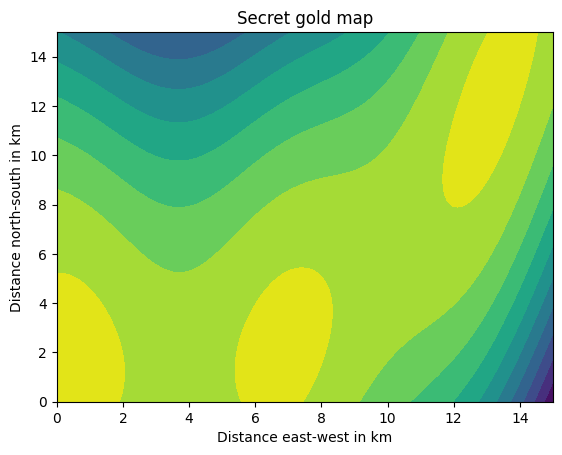

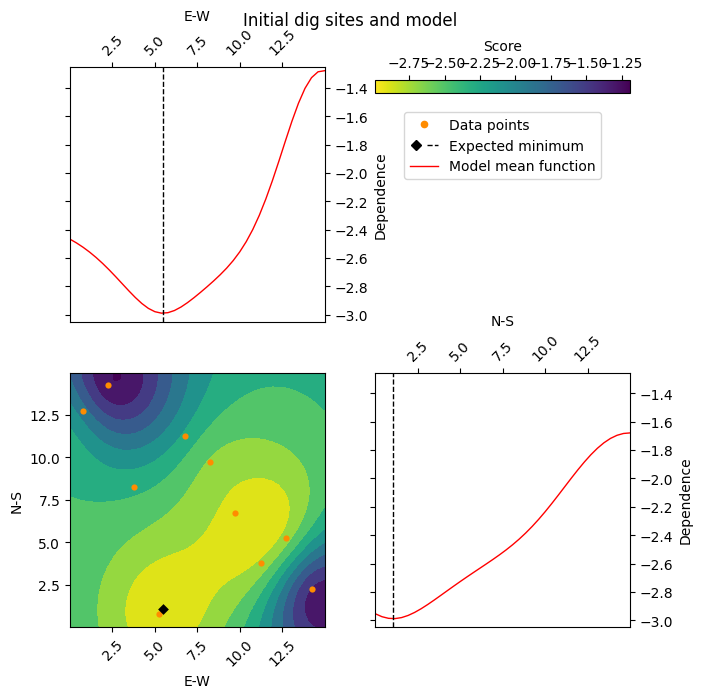

In [29]:
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import ProcessOptimizer
from ProcessOptimizer.model_systems.model_system import ModelSystem

#Setting random seed to ensure reproducible behaviour
np.random.seed(42)

VERBOSE = False

coordinates = [(0, 15.0),(0,15.0)]

def score(coordinates: List[int]):
    """ Modified Branin-Hoo function. It has three local minima.
    More details: <http://www.sfu.ca/~ssurjano/branin.html>
    """
    x = 10-coordinates[0]
    y = coordinates[1]
    gold_found = ((y - 1/8 * x ** 2 + 1.6 * x - 6) ** 2 + 10 * np.cos(x) - 299)/100
    if VERBOSE:
        print(f"We dug at {coordinates} and found {-round(gold_found*10)/10} mg gold.")
    return gold_found

# Making the data model
data_model = ModelSystem(score=score,space=coordinates,noise_model="zero")

opt = ProcessOptimizer.Optimizer(dimensions=coordinates)
# For each of the first 10 positions
for index in range(10):
    # Find the place to dig
    new_dig_site = opt.ask()
    # Digging for gold
    gold_found = data_model.get_score(new_dig_site)
    # Telling the optimiser how uch gold we found
    result = opt.tell(new_dig_site, gold_found)


#Plotting the secret map
# Making the lists of x and y coordinates
x_list = np.linspace(coordinates[0][0],coordinates[0][1],100)
y_list = np.linspace(coordinates[1][0],coordinates[1][1],100)

(x_mesh,y_mesh) = np.meshgrid(x_list,y_list)
score_mesh = [[-data_model.score((x,y)) for (x,y) in zip(x_vec,y_vec)] 
              for (x_vec,y_vec) in zip(x_mesh,y_mesh)]
plot = plt.contourf(x_mesh,y_mesh,score_mesh,10)
plot.axes.set_xlabel("Distance east-west in km")
plot.axes.set_ylabel("Distance north-south in km")
plot.axes.set_title("Secret gold map")
ProcessOptimizer.plot_objective(
    result=result,
    pars="expected_minimum",
    dimensions = ["E-W","N-S"],
    title="Initial dig sites and model");

## Plotting the uncertainty

The plot we just made doesn't express the entirity of the model. In addition to the
expected value at different possible dig sites, the model also contains a measure of how
certain it is about the amount of gold that can be found at each site. We can include
this information in the 2D plot.

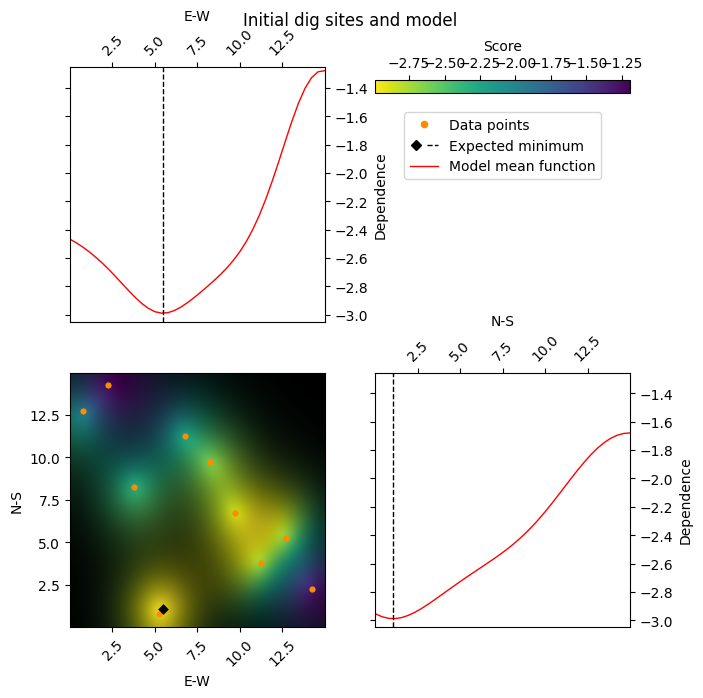

In [30]:
ProcessOptimizer.plot_objective(
    result=result,
    pars="expected_minimum",
    dimensions = ["E-W","N-S"],
    title="Initial dig sites and model",
    plot_options = {"interpolation": "bicubic"});

The intensity of the color in the lower left plot shows how certain the model is; the
darker the color, the more uncertain the estimate is. Let's try and add some more
points, and look at how that affects the uncertainty.

We dug at [7.212687493096595, 2.928665444152217] and found 3.1 mg gold.
We dug at [6.938708780897123, 2.3170351352458156] and found 3.1 mg gold.
We dug at [14.1741374403019, 13.363115718932365] and found 3.0 mg gold.
Plotting model after 3 digs
We dug at [12.693149771961764, 9.929273859629795] and found 3.1 mg gold.
We dug at [7.293072573966163, 1.8037003612003055] and found 3.1 mg gold.
We dug at [0.0, 0.0] and found 3.0 mg gold.
We dug at [0.0, 3.2632122374015493] and found 3.1 mg gold.
We dug at [13.31306835277687, 15.0] and found 3.0 mg gold.
We dug at [1.8447933129012897, 1.5346052738054328] and found 3.0 mg gold.
Plotting model after 9 digs
We dug at [12.897956929122879, 12.282908745049244] and found 3.1 mg gold.
We dug at [12.221636353161053, 11.192359083882842] and found 3.0 mg gold.
We dug at [6.411387790206419, 2.899247403209082] and found 3.1 mg gold.
We dug at [0.0, 5.7041247255340455] and found 3.0 mg gold.
We dug at [13.238949482998656, 11.592632984293289] and found 3.1 m

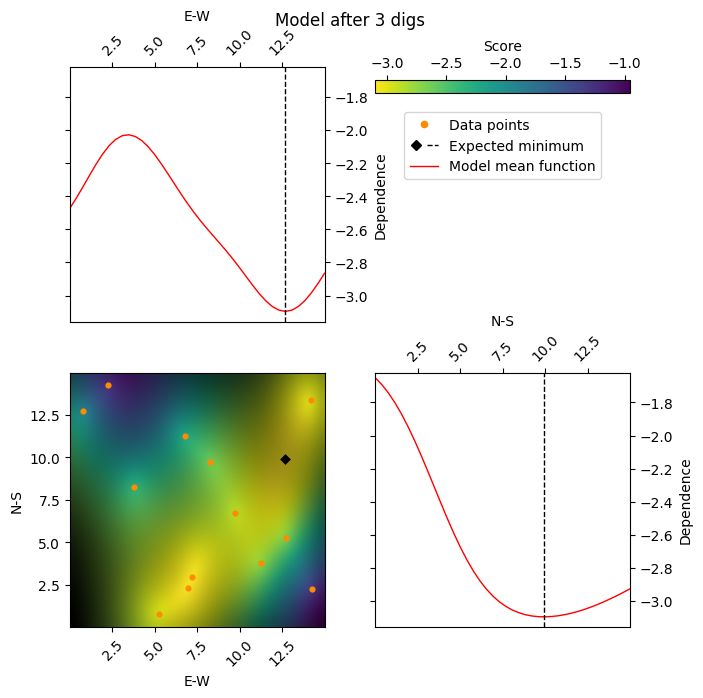

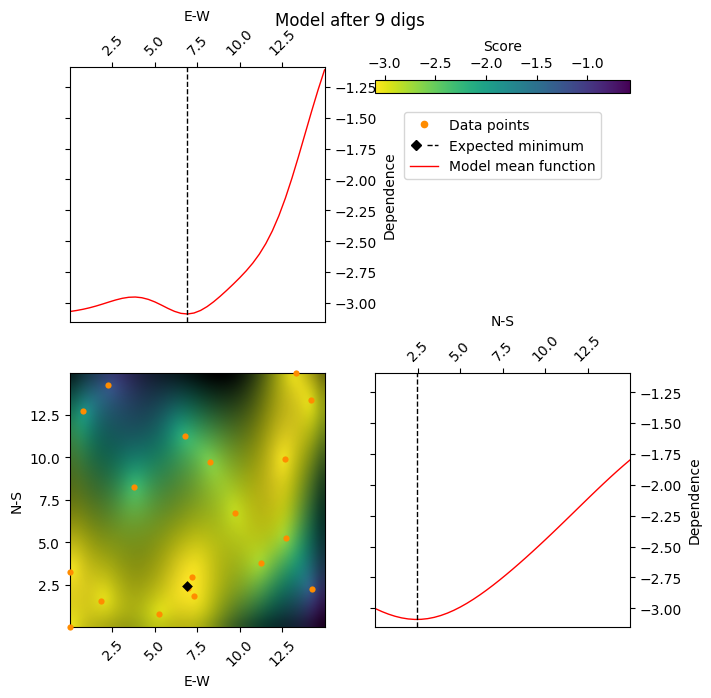

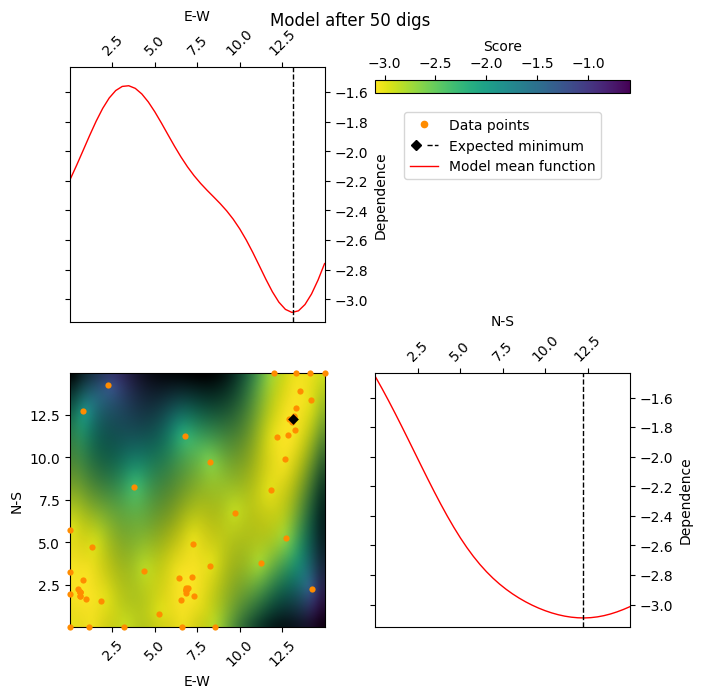

In [31]:
VERBOSE = True
dig_report = [3,9,50] # When to draw plots
for dig_number in range(max(dig_report)):
    new_point = opt.ask()
    gold_found = data_model.get_score(new_point)
    result = opt.tell(new_point,gold_found)
    if dig_number+1 in dig_report:
        print(f"Plotting model after {dig_number+1} digs")
        ProcessOptimizer.plot_objective(
            result=result,
            pars="expected_minimum",
            dimensions = ["E-W","N-S"],
            title=f"Model after {dig_number+1} digs",
            plot_options = {"interpolation": "bicubic"});

## Different ways of plotting uncertainty

By default, the uncertainty is plotted so that the minimum plotted uncertainty
corresponds to the ful colour, while the maximum plotted uncertainty corresponds to pure
black. We can change this by setting the value of 
`plot_options["normalize_uncertainty]`. This should be a function that accepts three
inputs:
* A numpy.array containing the standard deviations of the points to be plotted
* The minimum standard deviation
* The maximum standard deviation

And returns an numpy.array with a value between 0 and 1 for each point to be plotted. 0
means that the color of the point will only reflect the expected value, 1 represents
that the point will be black, and value in between are darkened according to the value.

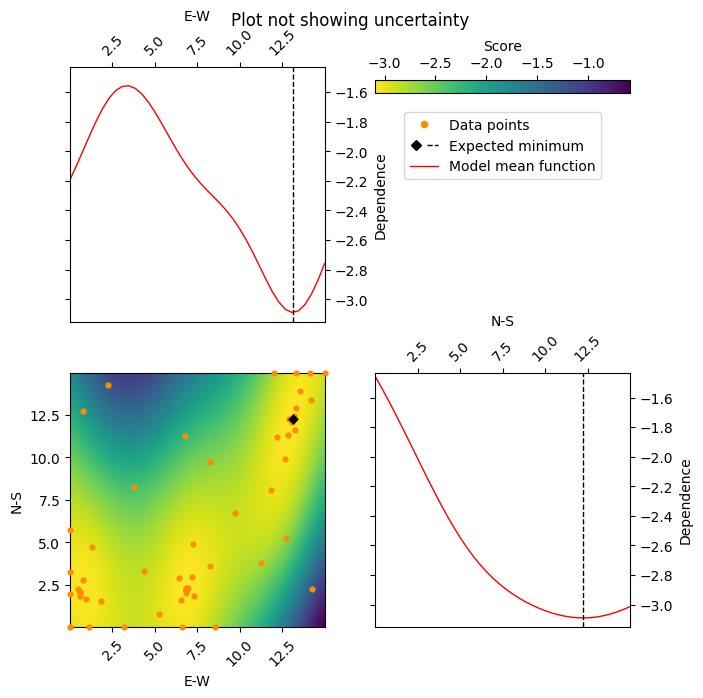

In [41]:
ProcessOptimizer.plot_objective(
    result=result,
    pars="expected_minimum",
    dimensions = ["E-W","N-S"],
    plot_options = {
        "interpolation": "bicubic",
        "normalize_uncertainty": lambda x,min,max: 0*x},
   title="Plot not showing uncertainty");

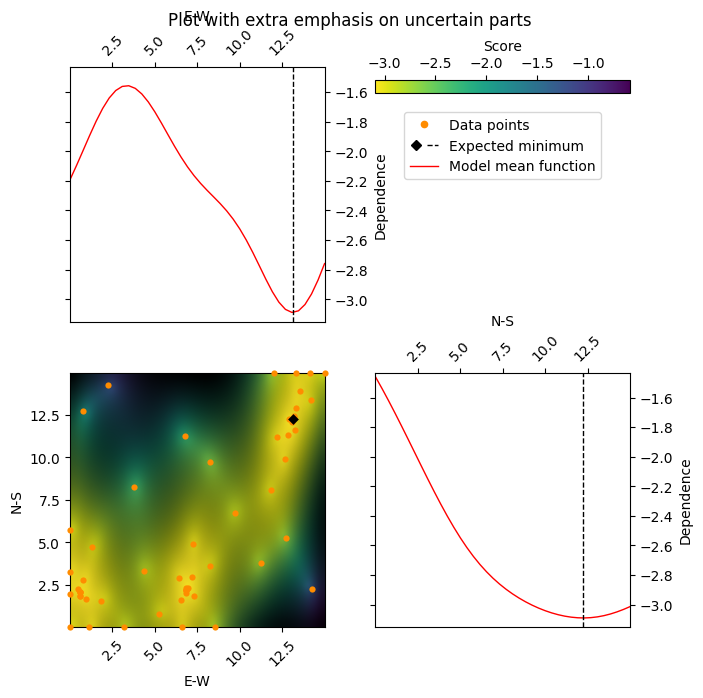

In [40]:
ProcessOptimizer.plot_objective(
    result=result,
    pars="expected_minimum",
    dimensions = ["E-W","N-S"],
    plot_options = {
        "interpolation": "bicubic",
        "normalize_uncertainty": lambda x,min,max: ((x-min)/max)**(1/2)},
    title="Plot with extra emphasis on uncertain parts");

## Remaining uncertainty

Note that even after 60 digs, there are still areas with relatively high uncertainty.
This is because the ProcessOptimizer tries to balance whether it expects to get a good
result from a dig with where it can learn something new. In the uncertain areas, the
expected value is so low that the ProcessOptimizer never investigates them. In the
notebook explore_vs_exploit.ipynb, we will see hw to modify this behavior.